# Exploration of the Data and Results

In [2]:
from __future__ import annotations
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

sns.set()
sns.set_style('whitegrid')

## Data Exploration

In [3]:
from enum import Enum, auto
class Caso(Enum):
    TEST = auto()
    TRAIN = auto()
    
class Language(Enum):
    ESP = auto()
    ENG = auto()

In [4]:
data_path = Path("data/public_data/")
if not data_path.exists():
    raise FileNotFoundError("No se encuentra el directorio con los datos")
train_path = Path(data_path / "SatiSPeech_phase_2_train_public.csv")
test_path = Path(data_path / "SatiSPeech_phase_2_test_public.csv")
fig_path = Path("WorkingNotes/figures/")
fig_path.mkdir(exist_ok=True)
df = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df

,id,label,transcription
0,5eef381b-7c3102ad.mp3,satire,"Yo creo que ya lo dice la propia frase, es pri..."
1,3db0b886-434a22fd.mp3,no-satire,"El presidente de Estados Unidos, Barack Obama,..."
2,1e3fd1a7-dfd534d8.mp3,satire,El presidente Andrés Manuel López Obrador visi...
3,2f593981-4087fa79.mp3,satire,"La sedición, porque inflación puede haber en c..."
4,815c0b94-1002ecaa.mp3,no-satire,Frenar la escalada de violencia en Gaza es una...
...,...,...,...
5995,3982793b-e3c0ec4a.mp3,no-satire,Pero la oficina del presidente francés dice qu...
5996,f0442261-0348093a.mp3,satire,No sé cómo se dice en castellano. Está siendo ...
5997,64ea7bec-c46cfd71.mp3,no-satire,"Sí, porque Rajoy dice que la razón de que esa ..."
5998,59a76f7b-75cc8d14.mp3,no-satire,Francisco era conocido como Jimmy entre los se...


In [5]:
label_counts = df['label'].value_counts(normalize=True) * 100
labels = label_counts.index
percentages = label_counts.values

In [6]:
def plot_label_distribution_percentage(df, lan: Language, caso: Caso = Caso.TRAIN, ax=None):
    df = df.copy()
    label_counts = df['label'].value_counts(normalize=True) * 100
    labels = label_counts.index
    percentages = label_counts.values

    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4))

    sns.barplot(x=labels, y=percentages, palette='pastel', ax=ax)
    if lan == Language.ESP:
        if caso == Caso.TRAIN:
            title = 'Distribución porcentual de etiquetas (entrenamiento)'
        else:
            title = 'Distribución de la longitud de las transcripciones (test)'
        xlab = 'Etiqueta'
        ylab = 'Porcentaje (%)'
    else:
        if caso == Caso.TRAIN:
            title = 'Label distribution (training)'
        else:
            title = 'Label distribution (test)'
        xlab = 'Label'
        ylab = 'Percentage (%)'

    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlab, fontsize=12)
    ax.set_ylabel(ylab, fontsize=12)
    ax.set_ylim(0, 100)

    for i, p in enumerate(ax.patches):
        height = p.get_height() # type: ignore
        if height > 1:
            ax.text(p.get_x() + p.get_width()/2., height + 1, # type: ignore
                    f'{height:.2f}%', ha="center", fontsize=11)

    return ax

Añadimos el path de los audios

In [7]:
df["path"] = df["id"].apply(lambda x: f"{data_path}/segments_train/{x}")
df_test["path"] = df_test["uid"].apply(lambda x: f"{data_path}/segments_test/{x}")
df_test.head()

,uid,transcription,path
0,fa8196b4-166b7bb9.mp3,La Comunidad de Madrid hace frente así a la sa...,data/public_data/segments_test/fa8196b4-166b7b...
1,b407b2e7-63887829.mp3,Los féretros han sido trasladados a Chiclana y...,data/public_data/segments_test/b407b2e7-638878...
2,91cfff91-f54d3c31.mp3,"Esto que parece una obviedad, ser contundentes...",data/public_data/segments_test/91cfff91-f54d3c...
3,27e25c21-1cf4072b.mp3,Usted mismo reconoce que cada vez se parece má...,data/public_data/segments_test/27e25c21-1cf407...
4,bb4ddfe5-fe837a69.mp3,Vamos a escuchar a todos los miembros del Comi...,data/public_data/segments_test/bb4ddfe5-fe837a...


In [8]:
def plot_distr_palabras(df, caso: Caso, lan: Language, ax=None):
    df = df.copy()
    df["n_palabras"] = df["transcription"].apply(lambda x: len(str(x).split()))
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 4))
    sns.histplot(
        data=df,
        x="n_palabras",
        hue= None if caso == Caso.TEST else "label",
        bins=40,
        kde=True,
        element="step",
        ax=ax,
    )
    if lan == Language.ESP:
        if caso == Caso.TRAIN:
            title = "Distribución de la longitud de las transcripciones (entrenamiento)"
        else:
            title = "Distribución de la longitud de las transcripciones (test)"
        xlab = "Número de palabras por transcripción"
        ylab = "Frecuencia"
    else:
        if caso == Caso.TRAIN:
            title = "Transcription length distribution (training)"
        else:
            title = "Transcription length distribution (test)"
        xlab = "Words per transcription"
        ylab = "Frequency"
    ax.set_xlim(0,150)
    if ax.legend_ is not None:
        ax.legend_.set_title(None) # type: ignore
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    return ax

In [9]:
def plot_distr_audio(df, caso: Caso, lan: Language, ax=None):
    df = df.copy()
    df["duration"] = df["path"].apply(lambda p: librosa.get_duration(path=p))

    if ax is None:
        _, ax = plt.subplots(figsize=(7, 4))
    if lan == Language.ESP:
        if caso == Caso.TRAIN:
            title = "Duración de los audios (entrenamiento)"
        else:
            title = "Duración de los audios (test)"
        xlab = "Duración (s)"
        ylab = "Frecuencia"
    else:
        if caso == Caso.TRAIN:
            title = "Audio duration (training)"
        else:
            title = "Audio duration (test)"
        xlab = "Duration (s)"
        ylab = "Frequency"
    sns.histplot(
        data=df,
        x="duration",
        hue= None if caso == Caso.TEST else "label",
        bins=40,
        kde=True,
        element="step",
        ax=ax,
    )
    ax.set_xlim(10,25)
    if ax.legend_ is not None:
        ax.legend_.set_title(None) # type: ignore
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    return ax

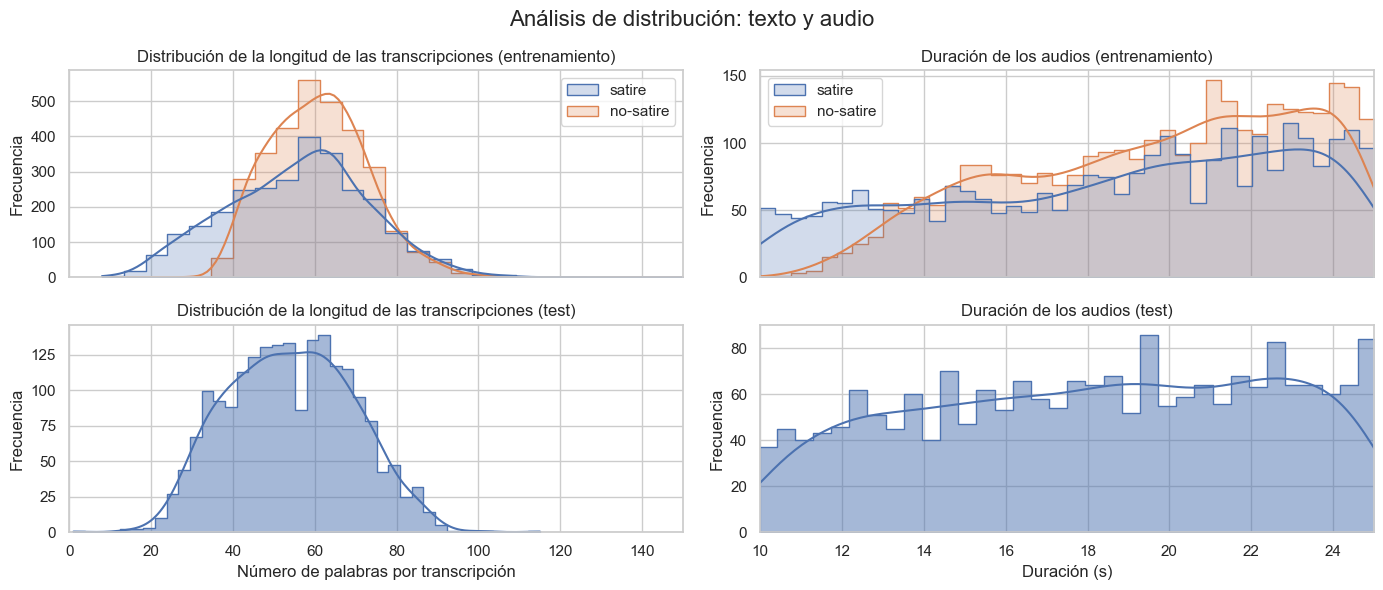

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 6), sharex='col')

plot_distr_palabras(df, caso = Caso.TRAIN, lan = Language.ESP, ax=axes[0][0])
plot_distr_audio(df, caso = Caso.TRAIN, lan = Language.ESP, ax=axes[0][1])
plot_distr_palabras(df_test, caso = Caso.TEST, lan = Language.ESP, ax=axes[1][0])
plot_distr_audio(df_test, caso = Caso.TEST, lan = Language.ESP, ax=axes[1][1])

fig.suptitle('Análisis de distribución: texto y audio', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)  # deja espacio para el título
plt.show()

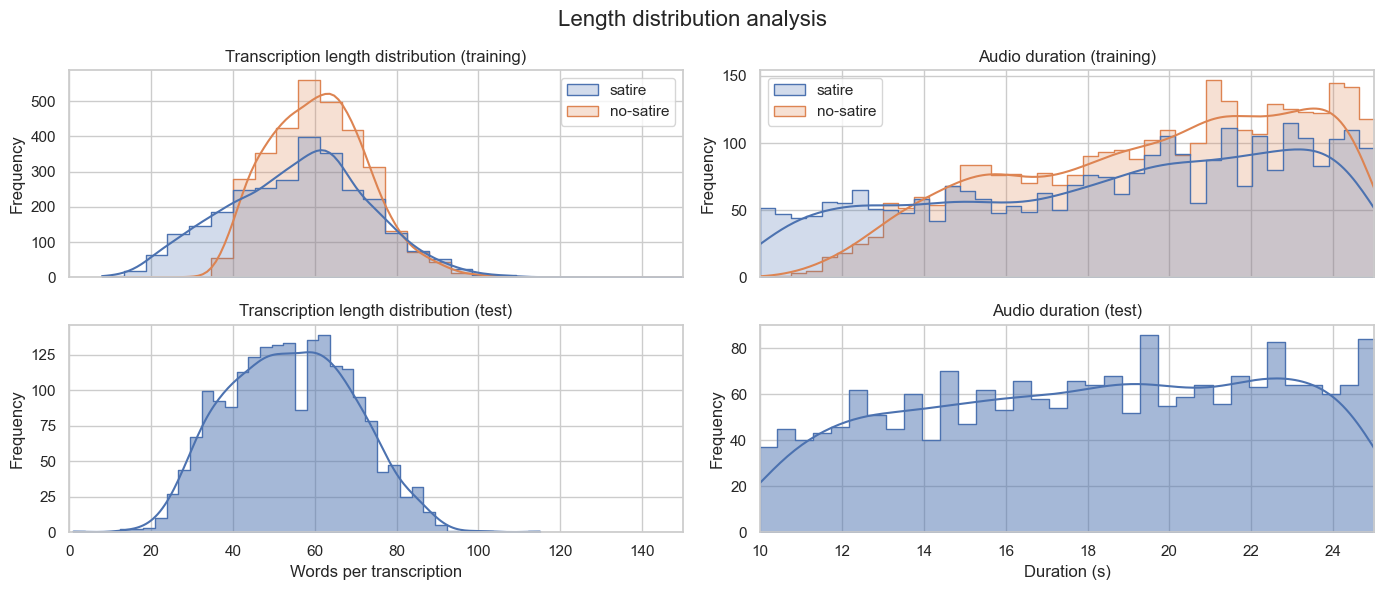

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 6), sharex='col')
lan = Language.ENG

plot_distr_palabras(df, caso = Caso.TRAIN, lan = lan, ax=axes[0][0])
plot_distr_audio(df, caso = Caso.TRAIN, lan = lan, ax=axes[0][1])
plot_distr_palabras(df_test, caso = Caso.TEST, lan = lan, ax=axes[1][0])
plot_distr_audio(df_test, caso = Caso.TEST, lan = lan, ax=axes[1][1])

fig.suptitle('Length distribution analysis', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)  
fig.savefig(fig_path/"duration_distribution.png", dpi = 300)
plt.show()

## Result exploration

In [12]:
import json
from typing import Optional
from dataclasses import dataclass

beautify_map = {
    "roberta": "RoBERTa",
    "fasttext": "FastText",
    "word2vec": "Word2Vec",
    "hubert": "HuBERT",
    "wav2vec2": "Wav2Vec2",
    "cls": "CLS",
    "mean": "Mean",
    "mfcc": "MFCC",
}

@dataclass
class Result:
    """ 
    Result of a single experiment.
    The class also provides static methods to load all the results from a directory or a JSON file.
    """
    name: str
    type: str
    fusion: Optional[str]
    model: str
    f1score: float
    
    @staticmethod
    def from_json(filepath: Path, beautify_name: bool = True) -> list[Result]:
        rs: list[Result] = []
        name: str
        type = filepath.parent.name
        if type == "combi":
            name = "_".join(filepath.stem.split("_")[:-1])
            fusion = filepath.stem.split("_")[-1] 
        else:
            name = filepath.stem
            fusion = None
        if beautify_name:
            for k,v in beautify_map.items():
                name = name.replace(k,v)
        with open(filepath) as f:
            results = json.load(f)
            for model, result in results.items():
                f1score = result["macro avg"]["f1-score"]
                rs.append(Result(name, type, fusion, model, f1score))
        return rs
    
    @staticmethod
    def from_dir(dirpath: Path) -> list[Result]:
        rs: list[Result] = []
        for f in dirpath.glob("**/*.json"):
            rs.extend(Result.from_json(f))
        return rs
    
    @staticmethod
    def get_df(results: list[Result]) -> pd.DataFrame:
        return pd.DataFrame([r.__dict__ for r in results])

In [13]:
combi = Result.get_df(Result.from_dir(Path("results/combi")))
audio = Result.get_df(Result.from_dir(Path("results/audio")))
text = Result.get_df(Result.from_dir(Path("results/text")))

In [ ]:
def plot_f1_overview(
    df: pd.DataFrame,
    title: Optional[str] = None,
    save_path: Optional[Path] = None,
):
    plt.figure(figsize=(10, 6))
    sns.barplot(
        df,
        x="name",
        y="f1score",
        hue="model",
    )
    plt.ylim(0.7, 1)
    plt.ylabel("Macro F1-Score")
    plt.xlabel("")
    title_str = "Macro F1-Score overview"
    if title:
        title_str += " - " + title
    plt.title(title_str, fontsize=14)
    plt.legend(title="")
    if save_path:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300)
    plt.show()

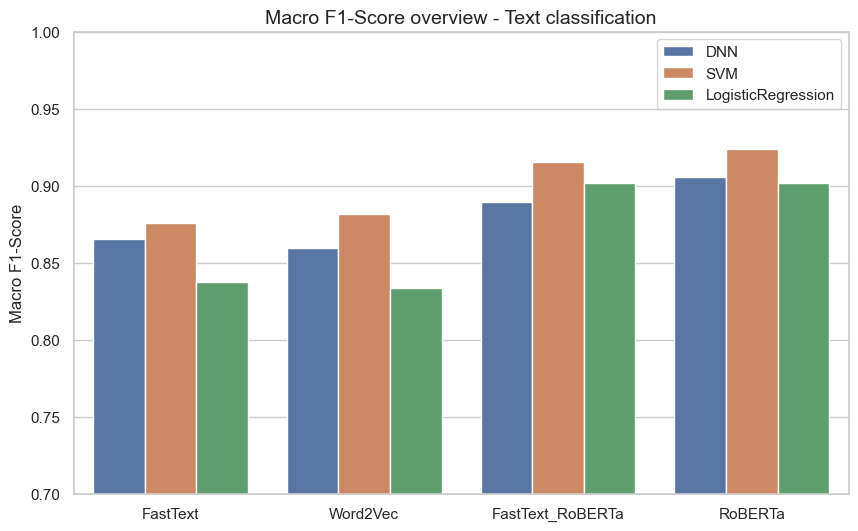

In [15]:
plot_f1_overview(
    text[text.model != "RandomForest"],
    "Text classification",
    Path("./figures/text_f1_overview.png")
)